# Combination investigation

this notebook investigates the distribution of block combinations in the dataset, which will guide architecture decisions

In [193]:
import os
import matplotlib.pyplot as plt
import json # .dat files are actually json
import numpy as np

In [35]:
# Define difficulty based on _difficultyRank present in info.dat

DIFFICULTIES = {
    "Easy": [1,2],
    "Normal": [3,4],
    "Hard": [5,6],
    "Expert": [7,8],
    "Expert+": [9]
}

In [248]:
# Analysis parameters

DIFFICULTY = "Expert+"
# DIFFICULTY = "Easy"


In [249]:
rootDir = "data/raw/CustomLevels/"
songs = os.listdir(rootDir)
print(f"{len(songs)} songs in the folder")
assert len(songs) > 0, "Folder doesn't contain any songs"

504 songs in the folder


In [250]:
# Make a list of all mappings of the specified difficulty rating

mappings = []

for song in songs:
    try:
        with open(os.path.join(rootDir, song, "info.dat")) as f:
            info = json.load(f)
        for dbs in info['_difficultyBeatmapSets']:
            for db in dbs['_difficultyBeatmaps']:
                if db['_difficultyRank'] in DIFFICULTIES[DIFFICULTY]:
                    mappings.append(os.path.join(rootDir, song, db['_beatmapFilename']))
    except Exception as e:
        print(e)
        
print(f"{len(mappings)} mappings left after difficulty filtering")
assert len(mappings) > 0, "mappings should have at least one mapping"

[Errno 2] No such file or directory: 'data/raw/CustomLevels/baa6 (Easy - alekcake)/info.dat'
[Errno 2] No such file or directory: 'data/raw/CustomLevels/Jaroslav Beck - Beat Saber (Built in)/info.dat'
248 mappings left after difficulty filtering


In [251]:
# Load the note lists for each song into memory

noteLists = {}

for mapping in mappings:
    with open(mapping) as f:
        noteLists[mapping] = json.load(f)['_notes']

### Notes

Notes contain the following information:

* "_time": the time step (seconds) when the event happens
* "_lineIndex": the column of the note (?)
* "_lineLayer": the row of the note (?)
* "_type": the colour of the note
* "_cutDirection": the direction in which to cut the note

Multiple notes can appear at the same timestep

### Analysis pt. 1

I don't know anything about mapping files and have never created one "the normal way". I think there should be 3 rows of 4 columns, but I need to first test this.


In [252]:
all_note_positions = []
for songTitle, songNotes in noteLists.items():
    # add them here first so we can not add them if it's a meme song later
    songNotePositions = []
    for note in songNotes:
        lineIndex, lineLayer = note['_lineIndex'],  note['_lineLayer']
        # keep it reasonable for songs that go overboard
        if lineIndex < -5 or lineIndex > 7 or lineLayer < -3 or lineLayer > 5:
            print(f"{songTitle} over limit")
            break
        else:
            songNotePositions.append({"LI": lineIndex, "LL": lineLayer})
    all_note_positions.extend(songNotePositions)

data/raw/CustomLevels/645a (A B Y S S - rustic)/ExpertPlusStandard.dat over limit
data/raw/CustomLevels/67ba (Air - gВvarred)/ExpertPlus.dat over limit
data/raw/CustomLevels/8eec (LA Devotee - night)/ExpertPlusStandard.dat over limit
data/raw/CustomLevels/97ac (Unholy Crusade - cyansnow)/ExpertPlusStandard.dat over limit


In [253]:
miLI = min([a['LI'] for a in all_note_positions])
maLI = max([a['LI'] for a in all_note_positions])
miLL = min([a['LL'] for a in all_note_positions])
maLL = max([a['LL'] for a in all_note_positions])

print(f"min lineIndex : {miLI}")
print(f"max lineIndex : {maLI}")
print(f"min lineLayer : {miLL}")
print(f"max lineLayer : {maLL}")

min lineIndex : -2
max lineIndex : 5
min lineLayer : 0
max lineLayer : 2



#### for my songs on Expert+:

* min lineIndex : -2
* max lineIndex : 5
* min lineLayer : 0
* max lineLayer : 2

Seems like reasonable songs only use 3 rows and at most 8 columns

### Analysis pt. 2

number of locations:

$ n_{loc8} = \_lineIndex \cdot \_lineLayer = 8 \cdot 3 = 24 $

number of block types:

$ n_{block} = \_type \cdot \_cutDirection = 2 \cdot 9 = 18 $

The max number of states for a block is:

$ b_1 = n_{loc8} \cdot n_{block} = 432$

However, multiple blocks are allowed. This means the total number of possible arrangements at one time step are:

$ b_{all} = (n_{block} + 1)^{n_{loc8}} >10^{30} $


Let's analyse the block positions to see if any can be discarded


In [254]:
# initialise heatmap as matrix of 0's
heatMap = np.zeros((maLL-miLL+1, maLI-miLI+1), dtype="uint32")

for note in all_note_positions:
    heatMap[note['LL'] - miLL ][note['LI'] - miLI ] += 1
    
print(heatMap)

[[  522   525 29887 49679 49274 24812   502   471]
 [  298   394 23050  2856  2829 24206   369   273]
 [  270   310  9228 10981 10970  9643   307   259]]


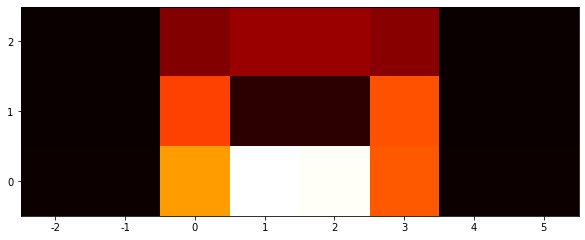

In [255]:
# plot the heatmap (upside down, since layer 0 is the ground layer)

plt.figure(figsize=(10,5))
plt.imshow(heatMap, cmap="hot", origin="lower")
plt.xticks(range(0, maLI - miLI + 1), range(miLI, maLI + 1))
plt.yticks(range(0, maLL - miLL + 1), range(miLL, maLL + 1))
plt.show()

It seems that the extended two blocks on each side are almost never used; they can be discarded for simplicity. Updating:

number of locations:

$ n_{loc} = \_lineIndex \cdot \_lineLayer = 4 \cdot 3 = 12 $

The max number of states for a block therefore drops down to:

$ b_1 = n_{loc} \cdot n_{block} = 216$

And all possible arrangements for a time step, allowing everything:

$ b_{all} = (n_{block} + 1)^{n_{loc}} > 10^{15} $

still a huge number. Let's only allow at most 2 blocks, one for the right hand and one for the left hand.

$ b_{2} = \_cutDirection^2 \cdot n_{loc} \cdot (n_{loc} - 1) = 10692 $

## Insight

Using CTC, better results might potentially be obtained by staggering left/right by a few milliseconds, thus enabling predictions in a significantly smaller feature space. However, I am still worried by the fact that encoding the entire state into an alphabet might make the model lose the semantics of what a position is, is \[2,3\] close to \[3,3\] etc. I'm therefore also considering multiple outputs with multiple loss functions, each handling a different aspect.

A transformer is also an option, by pre-segmenting the data it could simply spit out the current configuration block by block until it's done